In [4]:
import pickle
import json
import numpy as np
from pathlib import Path
import cv2
import torch
import pandas as pd
import pycocotools.mask as mask_util

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Raw samples

In [6]:
# DATA_PATH = Path('/home/bulat/Work/Sirius/DeWrapDoc-12.25/Datasets/real-test')
DATA_PATH = Path('/home/student03/work/datasets/demo_perspective_dataset')
WORK_DIR = Path('../../work_dir')
OUT_DIR = Path('../../out_dir')

annotations = pd.read_csv(DATA_PATH / 'annotations_demo.csv')
annotations.shape

(1048, 7)

In [7]:
annotations

,filename,filepath,width,height,coords,visibility,dataset
0,0000.jpg,demo_perspective_dataset/images/0000.jpg,1984,2806,"[[0.22782027336858934, 0.27062100813546863], [...","[1, 1, 1, 1]",perspective_demo
1,0001.jpg,demo_perspective_dataset/images/0001.jpg,1984,2806,"[[0.2716733870967742, 0.1557377049180328], [0....","[1, 1, 1, 1]",perspective_demo
2,0002.jpg,demo_perspective_dataset/images/0002.jpg,1984,2806,"[[0.06401209677419355, 0.1382751247327156], [0...","[1, 1, 1, 1]",perspective_demo
3,0003.jpg,demo_perspective_dataset/images/0003.jpg,1984,2806,"[[0.07358870967741936, 0.1407697790449038], [0...","[1, 1, 1, 1]",perspective_demo
4,0004.jpg,demo_perspective_dataset/images/0004.jpg,1984,2806,"[[0.17893145161290322, 0.2523164647184604], [0...","[1, 1, 1, 1]",perspective_demo
...,...,...,...,...,...,...,...
1043,1043.jpg,demo_perspective_dataset/images/1043.jpg,1984,2806,"[[0.2878024193548387, 0.2459016393442623], [0....","[1, 1, 1, 1]",perspective_demo
1044,1044.jpg,demo_perspective_dataset/images/1044.jpg,1984,2806,"[[0.05040322580645161, 0.07163221667854597], [...","[1, 1, 1, 1]",perspective_demo
1045,1045.jpg,demo_perspective_dataset/images/1045.jpg,1984,2806,"[[0.12223426757320281, 0.10294297993905359], [...","[1, 1, 1, 1]",perspective_demo
1046,1046.jpg,demo_perspective_dataset/images/1046.jpg,1984,2806,"[[0.07026864636328913, 0.13024728330474875], [...","[1, 1, 1, 1]",perspective_demo


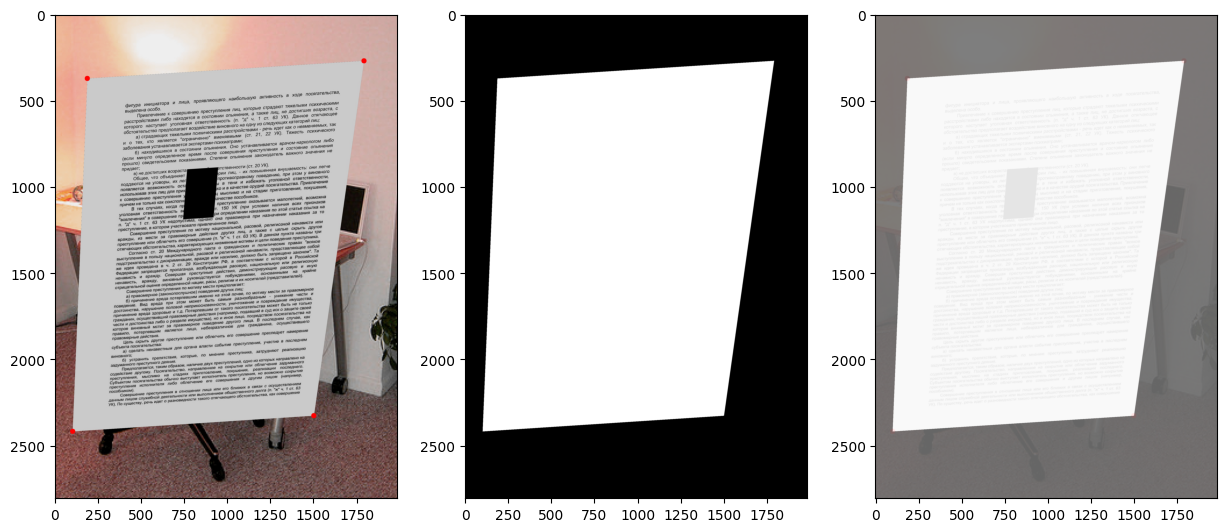

In [45]:
idx = np.random.randint(len(annotations))
filepath = annotations['filepath'].iloc[idx]
filepath = DATA_PATH.parent / Path(filepath)
maskpath = str(filepath).replace('images', 'masks').replace('jpg', 'png')
image = cv2.imread(filepath)
mask = cv2.imread(maskpath)
height, width = image.shape[:2]
coords = json.loads(annotations['coords'].iloc[idx])

for coord in coords:
    x, y = int(coord[0] * width), int(coord[1] * height) 
    cv2.circle(image, (x, y), 15, (0,0,255), -1)

plt.figure(figsize=(15, 7))
plt.subplot(1,3,1)
plt.imshow(image[:,:,::-1])

plt.subplot(1,3,2)
plt.imshow(mask)

plt.subplot(1,3,3)
plt.imshow(image[:,:,::-1], alpha=0.2)
plt.imshow(mask, alpha=0.5)

In [78]:
def order_points(pts: np.ndarray) -> np.ndarray:
    """
    Упорядочивает 4 точки в порядке:
    top-left, top-right, bottom-right, bottom-left.
    pts: массив формы (4, 2)
    """
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1) # x + y
    diff = np.diff(pts, axis=1) # y - x

    rect[0] = pts[np.argmin(s)] # top-left  (минимальная сумма)
    rect[2] = pts[np.argmax(s)] # bottom-right (максимальная сумма)
    rect[1] = pts[np.argmin(diff)] # top-right (минимальная разность)
    rect[3] = pts[np.argmax(diff)] # bottom-left (максимальная разность)
    return rect


def show_image(img, title=None, cmap=None, size=(6, 6)):
    """
    Удобный вывод изображения через matplotlib.
    img: BGR (OpenCV) или одноканальное изображение.
    """
    plt.figure(figsize=size)
    if len(img.shape) == 2:
        plt.imshow(img, cmap=cmap or "gray")
    else:
        # OpenCV читает в BGR, matplotlib ожидает RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
    if title is not None:
        plt.title(title)
    plt.axis("off")
    plt.show()

def find_contours(image, msk):

    # 1. Контуры
    if len(msk.shape) == 3:
        msk = msk[:,:,:1]
    contours, hierarchy = cv2.findContours(
        msk, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE
    )
    
    h, w = mask.shape[:2]
    img_area = h * w
    
    # 2. Фильтрация по площади
    candidates = [
        c for c in contours
        if 0.1 * img_area < cv2.contourArea(c) < 0.8 * img_area
    ]
    
    if not candidates:
        raise RuntimeError(
            "Не найдено ни одного контура подходящего размера. "
            "Попробуй изменить предобработку или границы 0.1 / 0.8."
        )
    
    # 3. Берём самый большой кандидат как страницу
    # page_contour = max(candidates, key=cv2.contourArea)
    sorted_candidates = sorted(candidates, key=cv2.contourArea)
    page_contour = sorted_candidates[-1]
    
    # 4. Пытаемся аппроксимировать контур четырёхугольником
    # 4.1 Вычесляемм периметр контура
    peri = cv2.arcLength(page_contour, True)
    # 4.1 Аппрокисимруем прямоугольником
    approx = cv2.approxPolyDP(page_contour,
                              0.02 * peri, # максимальное отклонение (epsilon) от исходной кривой
                              True         # замкнутый контур
                              )
    
    if len(approx) == 4:
        # Красивый случай — получили 4 точки по контуру
        quad = approx.reshape(4, 2).astype("float32")
        rect_pts = order_points(quad)
    else:
        # Иначе — минимальный ограничивающий прямоугольник
        rect = cv2.minAreaRect(page_contour)  # находит минимальный по площади повёрнутый прямоугольник, охватывающий контур
        box = cv2.boxPoints(rect)          # (4, 2)
        rect_pts = order_points(box.astype("float32"))
    
    # 5. Рисуем найденный четырёхугольник на исходном изображении
    
    # rect_pts: (4, 2) float32 -> (4, 1, 2) int для drawContours
    rect_cnt = rect_pts.reshape(-1, 1, 2).astype(int)
    
    vis = image.copy()  # или image.copy(), но БЕЗ несоответствия имён
    cv2.drawContours(vis, [rect_cnt], -1, (0, 255, 0), 5)
    
    show_image(vis, "Найденный четырёхугольник страницы")

    return rect_cnt

def find_kp(rect_cnt):
    # rect_cnt: (4, 1, 2) int -> (4, 2) float32
    box_pts = rect_cnt.reshape(-1, 2).astype("float32")
    
    # Упорядочиваем (tl, tr, br, bl)
    rect_pts = order_points(box_pts)
    
    print("Упорядоченные углы (tl, tr, br, bl):")
    print(rect_pts)
    
    vis_corners = image.copy()
    
    for (x, y) in rect_pts.astype(int):
        cv2.circle(vis_corners, (x, y), 25, (0, 255, 0), -1)
    
    show_image(vis_corners, "Углы страницы")

    return rect_pts

def dewarp(image, rect_pts):
    (tl, tr, br, bl) = rect_pts

    widthA = (np.linalg.norm(br - bl)).astype(int)
    widthB = (np.linalg.norm(tr - tl)).astype(int)

    print(widthA, widthB)
    
    maxWidth = max([widthA, widthB])
    
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = int(max([heightA, heightB]))
    
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")
    
    # Вычисляем 3x3 матрицу перспективного преобразования, сопоставляющую 4
    # соответствующие точки rect_pts (углы обнаруженного контура страницы A4)
    # с целевыми координатами dst
    M = cv2.getPerspectiveTransform(rect_pts, dst)
    
    # Применяет перспективное преобразование к изображению image с
    # использованием матрицы M (из cv2.getPerspectiveTransform), выравнивая страницу A4 в прямоугольник размером maxWidth x maxHeight пикселей
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    show_image(warped, "Документ после исправления перспективы")


### Train/Test samples

In [79]:
WORK_DIR = Path('../../work_dir')
OUT_DIR = Path('../../out_dir')

exp_name = '001'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


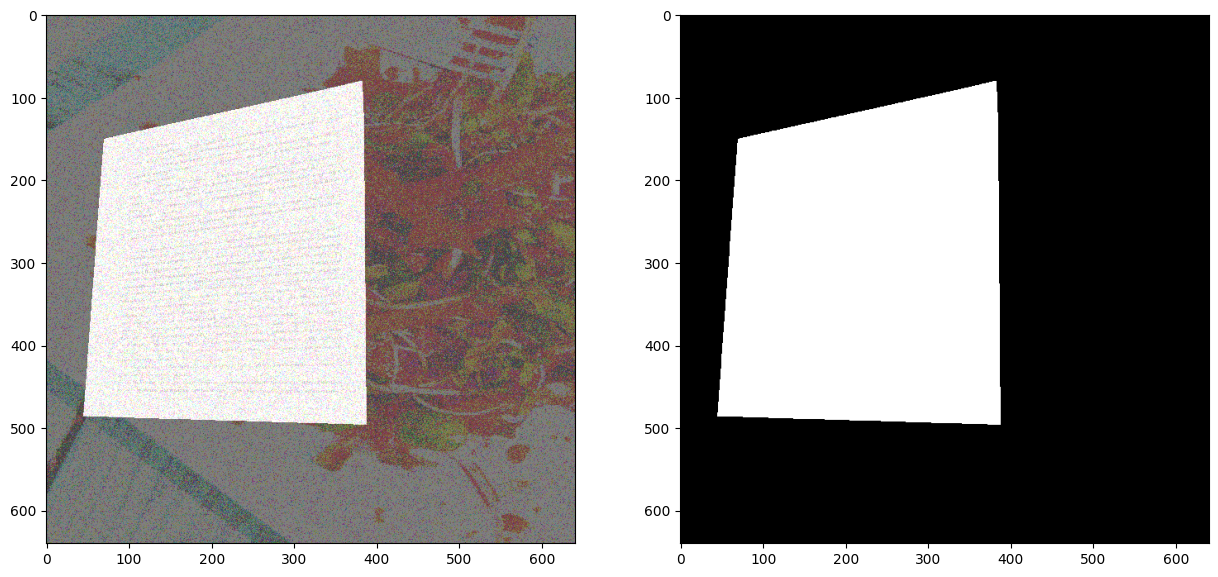

In [80]:
with open(WORK_DIR / 'sample.pkl', 'rb') as f:
    sample = pickle.load(f)

# images, image_path, im_size, coords = sample
images, image_path, im_size, masks = sample

idx = 1
image = images[idx].cpu().numpy().transpose(1, 2, 0)
mask = masks[idx].cpu().numpy().transpose(1, 2, 0)
height, width = image.shape[:2]

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, ::-1], alpha=0.5)
plt.imshow(mask, cmap='gray', alpha=0.5)

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')

plt.show();

### Predict result

In [119]:
PROJ_NAME = 'segm-docs'
EXP_NAME = 'unet-001'
# DATASET_NAME = 'demo_perspective_dataset'   
DATASET_NAME = 'datasets'   

OUT_DIR = Path('../../out_dir') / PROJ_NAME / EXP_NAME / DATASET_NAME
result_df = pd.read_csv(OUT_DIR / 'results.csv')
result_df.sample(10)

,size,counts,orig_size,fname
270,"[640, 640]",fhb32lc04L2M4N2N2N1L5M4N1O1N2N10002nMPOo@R1gNP...,"[1869, 1401]",/home/student03/work/datasets/real-test/rotate...
226,"[640, 640]",Sno14kc04M3L4M3M2N3M3M3L4M2N3M2N3L3N3M3M2N3M2M...,"[2048, 1536]",/home/student03/work/datasets/real-test/rotate...
258,"[640, 640]",U`m211020N3bc0?H2N2O1O2O001O1J500000001O001N20...,"[2048, 1536]",/home/student03/work/datasets/real-test/rotate...
183,"[640, 640]",STX26ic03T]O3_a00_^O3^a0Na^O5[a0Ob^O4Za0Od^O4Y...,"[2048, 1536]",/home/student03/work/datasets/real-test/rotate...
122,"[640, 640]",dkX18Zc0a0D8D;I9H8J6H6K7K420mEbMg2Z2mLQNX3k1bL...,"[1491, 1407]",/home/student03/work/datasets/real-test/perspe...
133,"[640, 640]",g][21oc0001O1O001N1XOLd]O5Zb0Me]O3[b0Nd]O2\b0N...,"[2048, 1536]",/home/student03/work/datasets/real-test/perspe...
269,"[640, 640]",Qg_13lc02O0O2O1N101N4M1N4M3L3N2N2M2O2M3N2N2M2O...,"[2002, 1501]",/home/student03/work/datasets/real-test/rotate...
321,"[640, 640]",ln]15ic05L1N10005J3M4M3L3N2M3N3L3N2M3N2M3U^OiN...,"[2048, 1536]",/home/student03/work/datasets/real-test/rotate...
307,"[640, 640]",Rl]2121O0dc0:N2e\OHib0i0DRO`]O0OQ1^b0<L6L2F<U^...,"[2048, 1536]",/home/student03/work/datasets/real-test/rotate...
193,"[640, 640]",\fW29dc04I6K7K7H7I<B9K4L5H9H;e^O[Mj`0Q3K3L4M4L...,"[2048, 1536]",/home/student03/work/datasets/real-test/rotate...


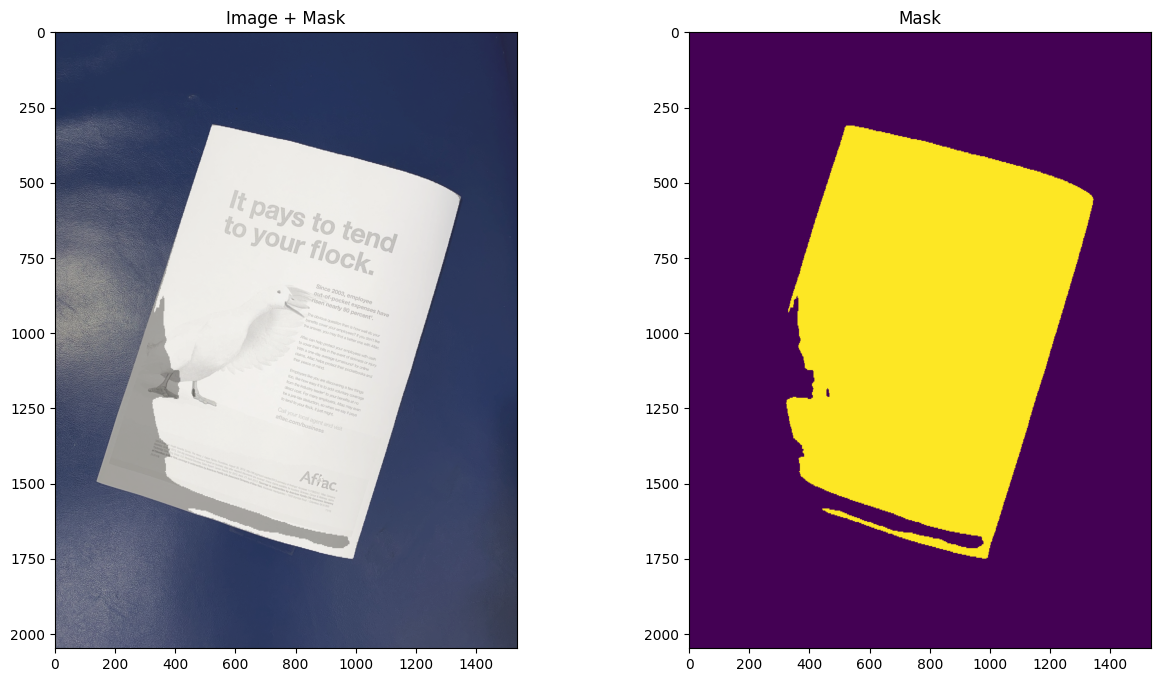

In [120]:
idx = np.random.randint(len(result_df))
filepath = result_df['fname'].iloc[idx]
image = cv2.imread(filepath, cv2.COLOR_BGR2RGB)
s = result_df['counts'].iloc[idx]
size = result_df['size'].iloc[idx]
rle = {
   'size' : json.loads(size),
   'counts': s.encode("utf-8")
}
mask = mask_util.decode(rle)
orig_size = json.loads(result_df['orig_size'].iloc[idx])
mask = cv2.resize(mask, orig_size[::-1], interpolation=cv2.INTER_NEAREST)

plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.imshow(image[:,:,::-1], alpha=0.8)
plt.imshow(mask, cmap='gray', alpha=0.3)
plt.title('Image + Mask')

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title('Mask')

plt.show()

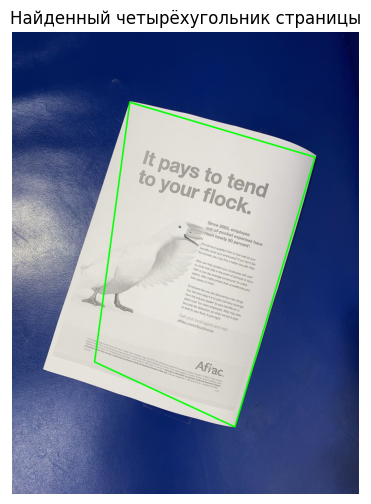

Упорядоченные углы (tl, tr, br, bl):
[[ 521.  311.]
 [1341.  554.]
 [ 986. 1750.]
 [ 365. 1462.]]


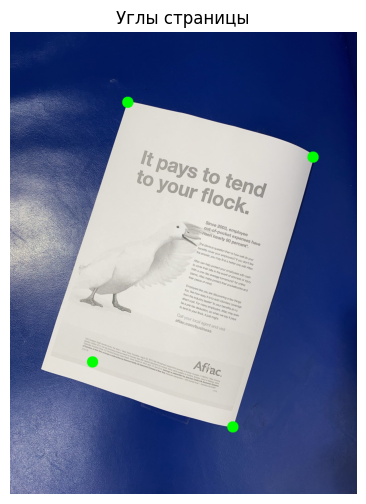

684 855


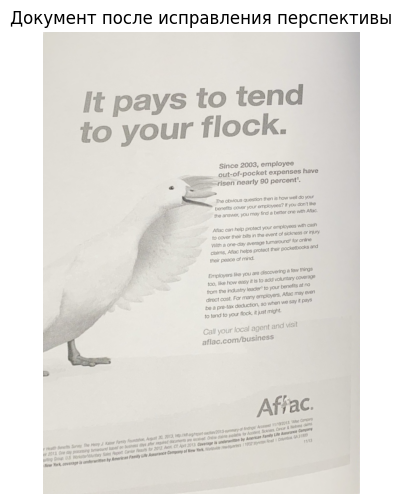

In [121]:
rect_cnt = find_contours(image, mask)
rect_pts = find_kp(rect_cnt)
dewarp(image, rect_pts)

In [118]:
max([1262, 1375])

np.int64(1375)